# Import

In [1]:
# import yfinance as yf
import pandas as pd
import os
from os.path import join
from datetime import datetime, timezone, timedelta
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import logging
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from yforseer.networks import StockNet
from yforseer.datasets import StockDataset
from yforseer.trainers import StockNetTrainer
import mlflow
from tqdm import tqdm

from yforseer.scraping import RawDF_Schema

# Dataset and loader

In [7]:

# Load dataset
load_array_pth = 'data/yahoo/artifacts/data_array.npz'
data = torch.from_numpy(np.load(load_array_pth)['data']).to(torch.float32)
num_days = data.shape[1]
test_size = int(0.1 * num_days)
train_size = num_days - test_size
train_data = data[:, :train_size]
test_data = data[:, train_size:]
train_dataset = StockDataset(data = train_data, memory=60, lookahead=30, mode='last')
test_dataset = StockDataset(data = test_data, memory=60, lookahead=30, mode='last')
print('train_dataset:', len(train_dataset))
print('test_dataset:', len(test_dataset))


train_dataset: 5283
test_dataset: 507


# Test evalutate

In [46]:
def weighted_return(change_pred, change_test, batch=True):
    if batch:
        buy_weights = np.abs(change_pred) / (np.abs(change_pred).sum(axis=1, keepdims=True) + 1e-8)
        buy_return = (change_test * buy_weights).sum(axis=1).squeeze()
    else:
        buy_weights = np.abs(change_pred) / (np.abs(change_pred).sum() + 1e-8)
        buy_return = (change_test * buy_weights).sum()
    return buy_return


In [34]:
xlast = np.repeat(xlast[np.newaxis, :], 3, axis=0)
xlast

array([[[  5,   5,   5],
        [ 10,  10,  10],
        [ 20,  20,  20],
        [200, 200, 200],
        [350, 350, 350],
        [100, 100, 100]],

       [[  5,   5,   5],
        [ 10,  10,  10],
        [ 20,  20,  20],
        [200, 200, 200],
        [350, 350, 350],
        [100, 100, 100]],

       [[  5,   5,   5],
        [ 10,  10,  10],
        [ 20,  20,  20],
        [200, 200, 200],
        [350, 350, 350],
        [100, 100, 100]]])

In [2]:
import numpy as np
from yforseer.evaluate import evaluate_stock_trend_prediction
xlast = np.array(
    [5, 10, 20, 200, 350, 100]
)
ypred = np.array(
    [20, 2, 24, 180, 450, 50]
)
ytest = np.array(
    [10, 7, 18, 210, 500, 10]
)


batch = False
# xlast = np.repeat(xlast[np.newaxis, :], 2, axis=0)
# ypred = np.repeat(ypred[np.newaxis, :], 2, axis=0)
# ytest = np.repeat(ytest[np.newaxis, :], 2, axis=0)
# batch = True


(trend_accuracy, null_accuracy_rise, null_accuracy_drop), (buy_returns, perfect_buy_returns), (sell_returns, perfect_sell_returns) = evaluate_stock_trend_prediction(xlast, ypred, ytest, batch=batch)

print('trend_accuracy:', trend_accuracy)
print('null_accuracy_rise:', null_accuracy_rise)
print('null_accuracy_drop:', null_accuracy_drop)
print('buy_returns:', buy_returns)
print('perfect_buy_returns:', perfect_buy_returns)
print('sell_returns:', sell_returns)
print('perfect_sell_returns:', perfect_sell_returns)


trend_accuracy: 0.6666666666666666
null_accuracy_rise: 0.5
null_accuracy_drop: 0.5
buy_returns: [1.         0.89004684 0.89004684]
perfect_buy_returns: [0.99999999 0.76782376 0.76782376]
sell_returns: [0.3        0.48928571 0.48928571]
perfect_sell_returns: [0.29999999 0.71799999 0.71799999]


In [76]:
xlast

array([[  5,  10,  20, 200, 350, 100],
       [  5,  10,  20, 200, 350, 100]])

In [15]:
import numpy as np
from yforseer.evaluate import evaluate_stock_trend_prediction, weighted_return
xlast = np.array(
    [5, 10, 20, 200, 350, 100]
)
ypred = np.array(
    [20, 2, 24, 180, 450, 50]
)
ytest = np.array(
    [10, 7, 18, 210, 500, 10]
)


batch = False
xlast = np.repeat(xlast[np.newaxis, :], 2, axis=0)
ypred = np.repeat(ypred[np.newaxis, :], 2, axis=0)
ytest = np.repeat(ytest[np.newaxis, :], 2, axis=0)
batch = True



change_pred = (ypred - xlast) / xlast
change_test = (ytest - xlast) / xlast

change_pred_rise = change_pred.copy()
change_test_rise = change_test.copy()
fall_mask = change_pred > 0
change_pred_rise[fall_mask] = 0
change_test_rise[fall_mask] = 0
print(np.argsort(change_pred_rise))
sorted_inds = np.argsort(-change_pred_rise, axis=-1)

M = sorted_inds.shape[-1]

buy_returns = []
perfect_buy_returns = []
for i in [1, 3, M]:
    # selected_tops_inds = sorted_inds[-i:]

    if batch:
        selected_tops_inds = sorted_inds[:, -i:]
        sorted_change_pred = np.take_along_axis(change_pred_rise, selected_tops_inds, axis=1)
        sorted_change_test = np.take_along_axis(change_test_rise, selected_tops_inds, axis=1)

    else:
        selected_tops_inds = sorted_inds[-i:]
        sorted_change_pred = change_pred_rise[selected_tops_inds]
        sorted_change_test = change_test_rise[selected_tops_inds]

    buy_return = weighted_return(sorted_change_pred, -sorted_change_test, batch=batch)
    perfect_buy_return = weighted_return(sorted_change_test, -sorted_change_test, batch=batch)
    buy_returns.append(buy_return)
    perfect_buy_returns.append(perfect_buy_return)

print('buy_returns:', buy_returns)



[[1 5 3 0 2 4]
 [1 5 3 0 2 4]]
buy_returns: [array([0.3, 0.3]), array([0.48928571, 0.48928571]), array([0.48928571, 0.48928571])]


In [13]:
sorted_inds

array([[0, 2, 4, 3, 5, 1],
       [0, 2, 4, 3, 5, 1]], dtype=int64)

In [61]:
np.take_along_axis(change_pred_rise, sorted_inds, axis=1)

array([[0.        , 0.        , 0.        , 0.2       , 0.28571429,
        3.        ],
       [0.        , 0.        , 0.        , 0.2       , 0.28571429,
        3.        ],
       [0.        , 0.        , 0.        , 0.2       , 0.28571429,
        3.        ]])

In [26]:
[1 3 5 2 4 0]
buy_return: 1.0
perfect_buy_return: 1.0
buy_return: 0.8900468384074941
perfect_buy_return: 0.7678237650200268
buy_return: 0.8900468384074941
perfect_buy_return: 0.7678237650200268

array([ 1.        ,  0.        , -0.1       ,  0.        ,  0.42857143,
        0.        ])

[1 3 5 2 4 0]
buy_return: 1.0
perfect_buy_return: 1.0
buy_return: 0.9503105590062112
perfect_buy_return: 0.8285714285714285
buy_return: 0.8900468384074941
perfect_buy_return: 0.7678237650200268
buy_return: 0.8900468384074941
perfect_buy_return: 0.7678237650200268


# Evaluate

In [30]:
import numpy as np
import matplotlib.pyplot as plt

results = np.load('predictions.npz')


x_test = results['x_test']
y_test = results['y_test']
y_pred = results['y_pred']


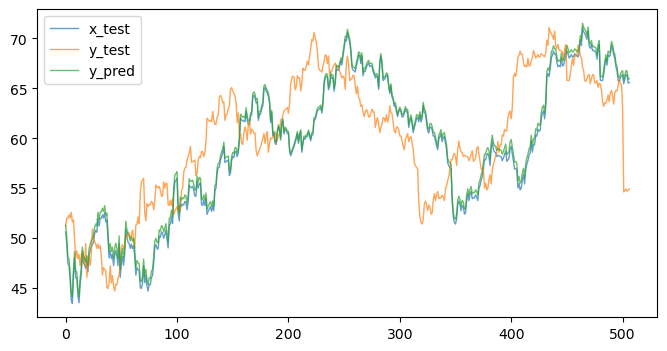

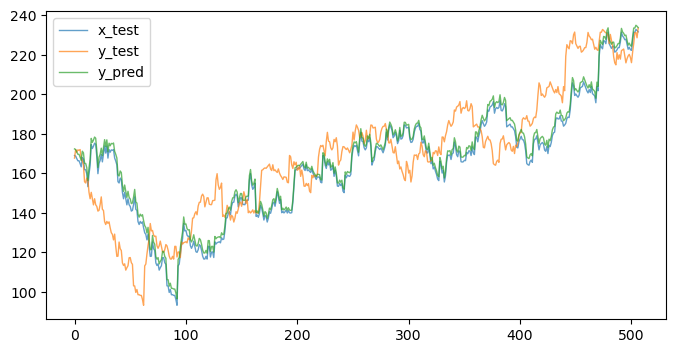

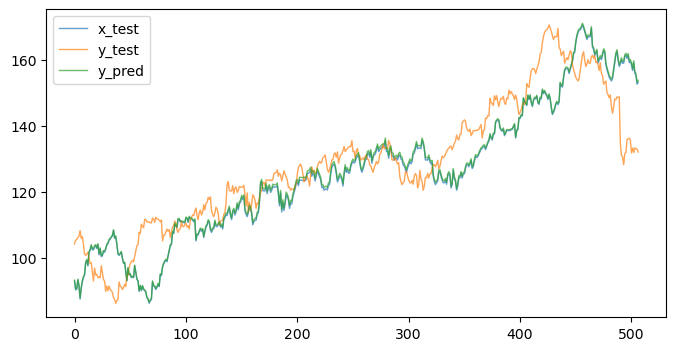

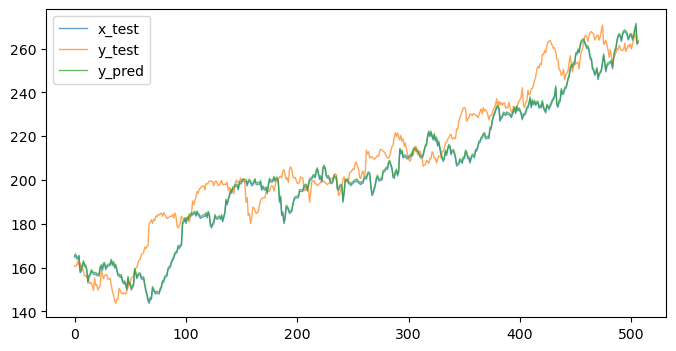

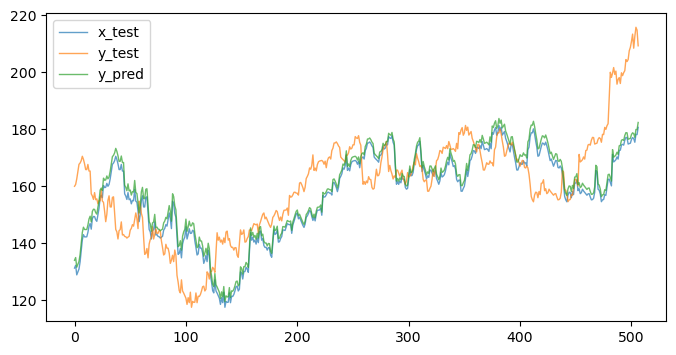

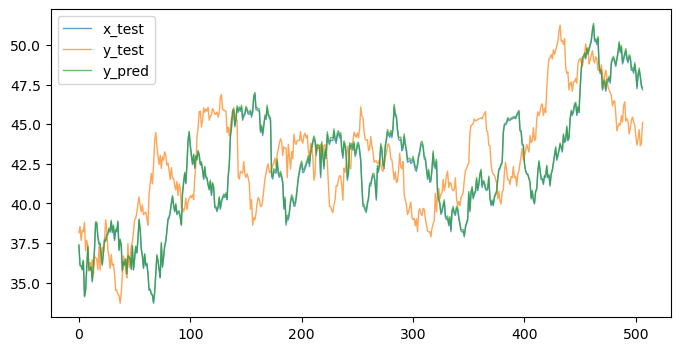

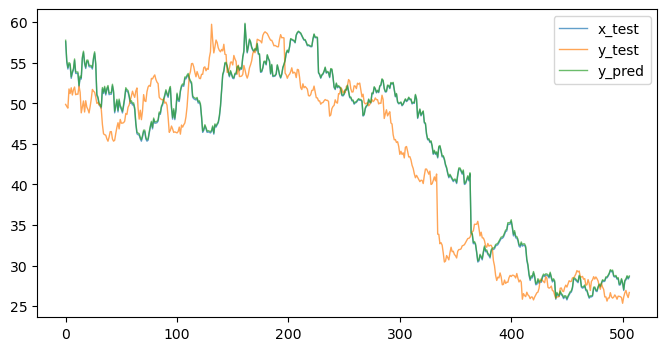

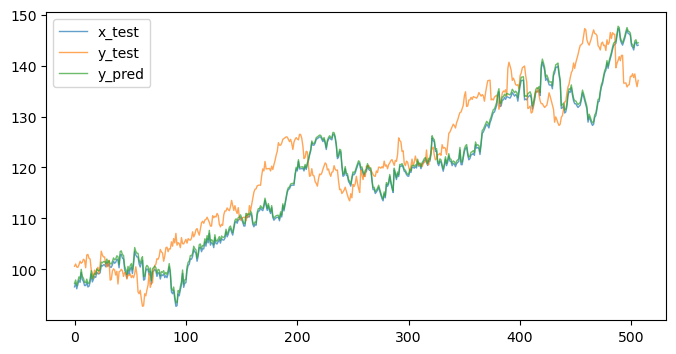

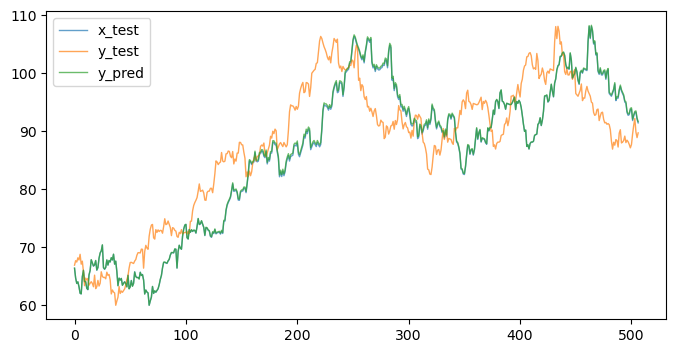

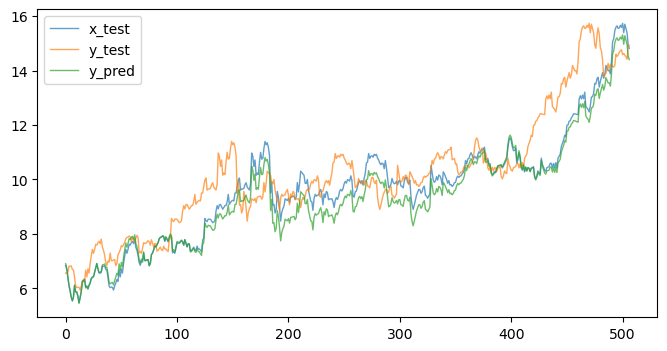

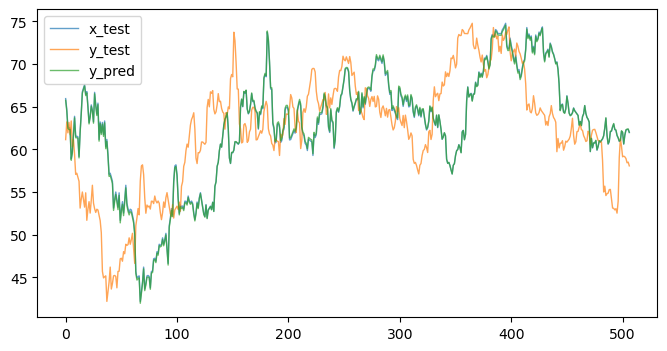

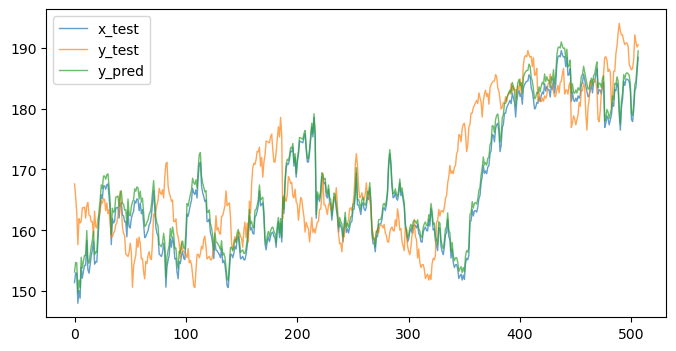

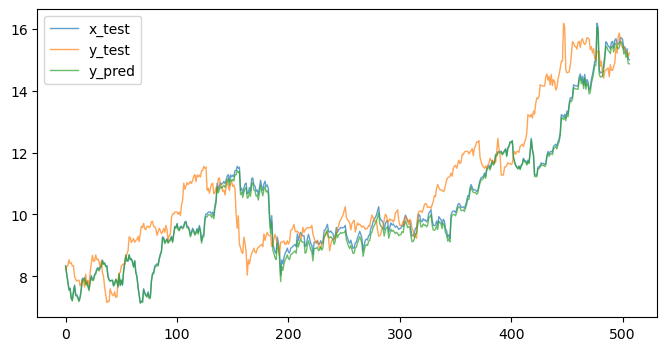

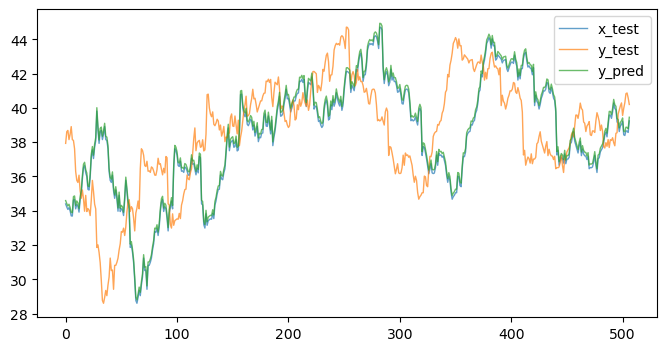

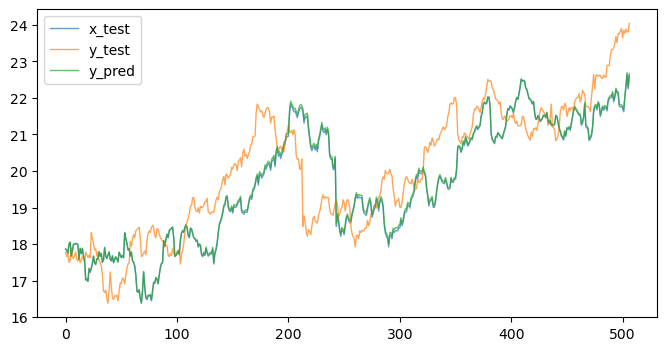

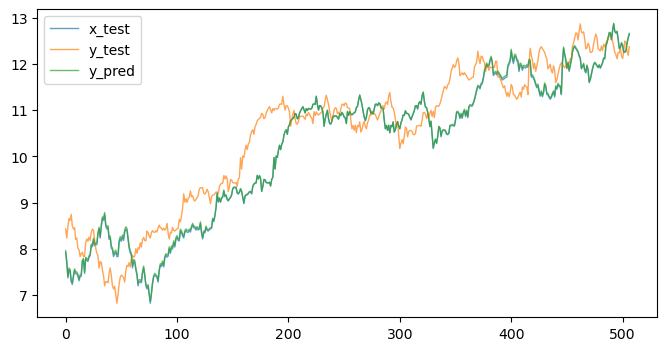

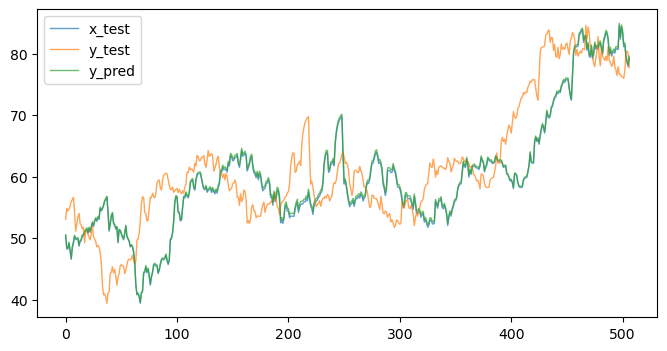

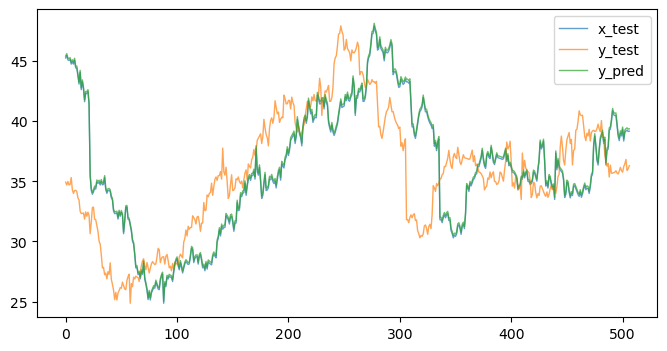

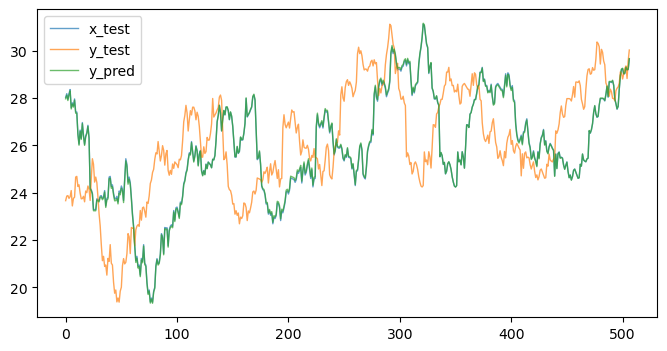

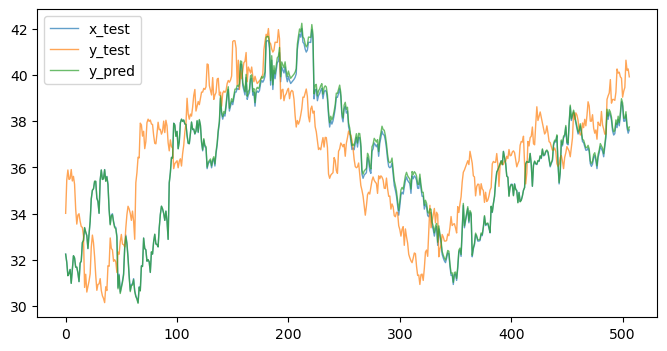

In [33]:
j = 0

tax = np.arange(x_test.shape[0])

for j in range(20):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(tax, x_test[:, j, -1], label='x_test', alpha=0.7, linewidth=1)
    ax.plot(tax, y_test[:, j], label='y_test', alpha=0.7, linewidth=1)
    ax.plot(tax, y_pred[:, j], label='y_pred', alpha=0.7, linewidth=1)

    ax.legend()

# Train

In [2]:
from yforseer.networks import TemporalConvNet
from yforseer.trainers import Trainer

In [3]:
num_inputs = 37
num_channels = [64, 128, 64, 32, 8, 1]
lr = 0.0001
tcnn = TemporalConvNet(num_inputs=num_inputs, num_channels=num_channels)
trainer = Trainer(lr = lr, model=tcnn)




In [10]:
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

In [11]:
X_train, y_train = next(iter(train_data_loader))
print(X_train.shape)

torch.Size([32, 37, 60])


In [13]:
y_train.shape

torch.Size([32, 37, 1])

In [12]:
X = X_train.flatten(start_dim=0, end_dim=1).unsqueeze(1)
print(X.shape)

torch.Size([1184, 1, 60])


In [20]:
num_inputs = 37
num_channels = [64, 128, 64, 32, 8, 1]
tcnn = TemporalConvNet(num_inputs=num_inputs, num_channels=num_channels)
out = tcnn(X_train)
print(out.shape)

torch.Size([32, 1, 60])
